<a href="https://colab.research.google.com/github/vlad-danaila/machine-learning-workout/blob/master/Exercise_2_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip3 install torch torchvision

In [0]:
import torch as t
import torchvision as tv
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

**Data load**

In [0]:
BATCH_SIZE = 128
normalization_params = (.5, .5, .5)

train_transform = tv.transforms.Compose([
    tv.transforms.ColorJitter(brightness = .1, contrast = .1, saturation = .1, hue = .1),
    tv.transforms.RandomAffine(degrees = .2, shear = .2),
    tv.transforms.RandomHorizontalFlip(),
#     tv.transforms.RandomResizedCrop(32),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean = normalization_params, std = normalization_params)
])
test_trasnform = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean = normalization_params, std = normalization_params)
])

cifar10_train = tv.datasets.CIFAR10('.', train = True, transform = train_transform, download = True)
cifar10_test = tv.datasets.CIFAR10('.', train = False, transform = test_trasnform, download = True)

loader_train = t.utils.data.DataLoader(cifar10_train, BATCH_SIZE, shuffle = True)
loader_test = t.utils.data.DataLoader(cifar10_test, BATCH_SIZE, shuffle = True)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
CLASS_LABELS = 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'

def to_numpy(x):
  return x.cpu().detach().numpy()

def plot_img(img, label, prediction):
  img = to_numpy(img).transpose((1, 2, 0))
  plt.title(CLASS_LABELS[label], color = 'green' if prediction == label else 'red')
  plt.imshow(img)

In [0]:
# sample_x, sample_y = next(iter(loader_train))
# fig = plt.figure(figsize = (14, 7))

# for i in range(BATCH_SIZE):
  # fig.add_subplot(4, 8, i + 1, xticks = [], yticks = [])
  # plot_img(sample_x[i], sample_y[i], sample_y[i])

**Model**

In [0]:
class Cifar_10_Classifier(t.nn.Module):
  def __init__(self):
    super().__init__()
    self.feats = t.nn.Sequential(
      t.nn.BatchNorm2d(3),
      t.nn.Conv2d(3, 32, 3, padding = 1), 
      t.nn.ReLU(True),
      t.nn.MaxPool2d(2), # output 16
        
      t.nn.BatchNorm2d(32),
      t.nn.Conv2d(32, 64, 3, padding = 1),
      t.nn.ReLU(True), 
      t.nn.MaxPool2d(2), # output 8
    
      t.nn.BatchNorm2d(64),
      t.nn.Conv2d(64, 128, 3, padding = 1),
      t.nn.Dropout(0.2),
      t.nn.ReLU(True),
      t.nn.MaxPool2d(2), # output 4   
        
      t.nn.BatchNorm2d(128),
      t.nn.Conv2d(128, 256, 1),
      t.nn.Dropout(0.2),
      t.nn.ReLU(True),   

      t.nn.BatchNorm2d(256),
      t.nn.Conv2d(256, 512, 1),
      t.nn.Dropout(0.3),
      t.nn.ReLU(True),
      
      t.nn.BatchNorm2d(512),
      t.nn.Conv2d(512, 256, 1),
      t.nn.Dropout(0.3),

      t.nn.BatchNorm2d(256),
      t.nn.Conv2d(256, 10, 1),
      t.nn.Dropout(0.1),
      # t.nn.Conv2d(10, 10, 4)

      t.nn.BatchNorm2d(10),
    )
    self.fc = t.nn.Linear(10 * 4 * 4, 10)
    
  def forward(self, x):
    x = self.feats(x)
    x = x.view(-1, 10 * 4 * 4)
    x = self.fc(x)
    return x

In [0]:
def accuracy(y_pred, y):
  max_vals, max_indx = t.max(y_pred, 1)
  return t.sum(max_indx == y).item() / len(y)

In [0]:
EPOCHS = 30

model = Cifar_10_Classifier().cuda()
optimizer = t.optim.Adam(model.parameters(), lr = 1e-3)
loss_fn = t.nn.CrossEntropyLoss()
losses_train = []
losses_eval = []
accuracies_train = []
accuracies_eval = []

for epoch in range(EPOCHS):
  print('Epoch', epoch + 1)
  
  # Train
  epoch_train_loss = 0
  epoch_train_accuracy = 0
  model.train()
  for x, y in loader_train:
    x, y = x.cuda(), y.cuda()
    y_pred = model.forward(x)
    y_pred = y_pred.squeeze()
    loss = loss_fn(y_pred, y)
    epoch_train_loss += loss.item()
    epoch_train_accuracy += accuracy(y_pred, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  losses_train.append(epoch_train_loss / len(loader_train))
  accuracies_train.append(epoch_train_accuracy / len(loader_train))
  
  # Eval
  epoch_eval_loss = 0
  epoch_eval_accuracy = 0
  model.eval()
  with t.no_grad():
    for x, y in loader_test:
      x, y = x.cuda(), y.cuda()
      y_pred = model.forward(x)
      y_pred = y_pred.squeeze()
      loss = loss_fn(y_pred, y)
      epoch_eval_loss += loss.item()
      epoch_eval_accuracy += accuracy(y_pred, y)
  losses_eval.append(epoch_eval_loss / len(loader_test))
  accuracies_eval.append(epoch_eval_accuracy / len(loader_test))

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30


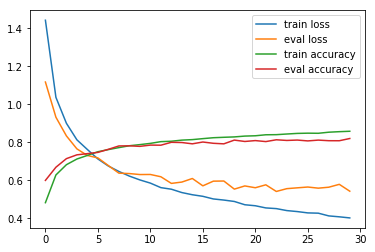

In [0]:
plt.plot(range(len(losses_train)), losses_train, label = 'train loss')
plt.plot(range(len(losses_eval)), losses_eval, label = 'eval loss')
plt.plot(range(len(accuracies_train)), accuracies_train, label = 'train accuracy')
plt.plot(range(len(accuracies_eval)), accuracies_eval, label = 'eval accuracy')
plt.legend()

In [0]:
print(accuracies_eval[-1])

0.8205102848101266
